In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from collections import Counter

from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [32]:
data_dir = "dataset/heart.csv"
df = pd.read_csv(data_dir)
df = df.dropna()


In [33]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [34]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

These types all look good, I would change them to ints or floats if they were anything else

According to the documentation, 0 means female and 1 means male

In [35]:
clr = df["sex"].map({0: "female", 1: "male"})

In [36]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

### Duplicated Values
We found comments about the dataset, claiming that there may be duplicate values. Let's search to see if there are indeed duplicates:

In [37]:
# Find and count duplicate rows
duplicate_rows = df[df.duplicated()]
duplicate_count = duplicate_rows.shape[0]

print("\nNumber of duplicate rows:", duplicate_count)



Number of duplicate rows: 723


We see that there are 723 duplicates, so let's remove them

In [38]:
df = df.drop_duplicates()

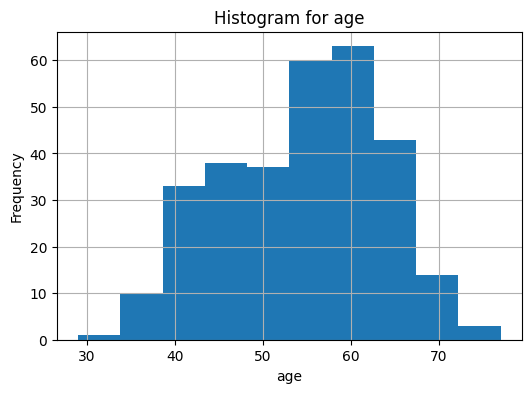

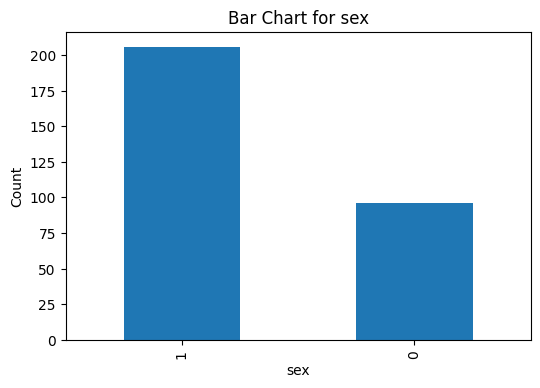

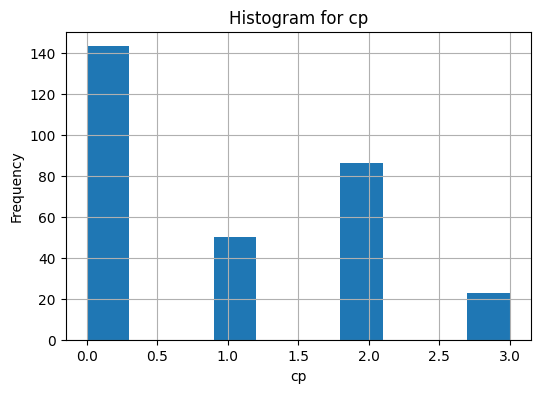

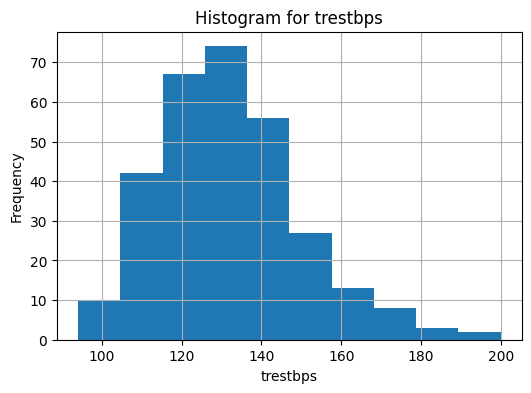

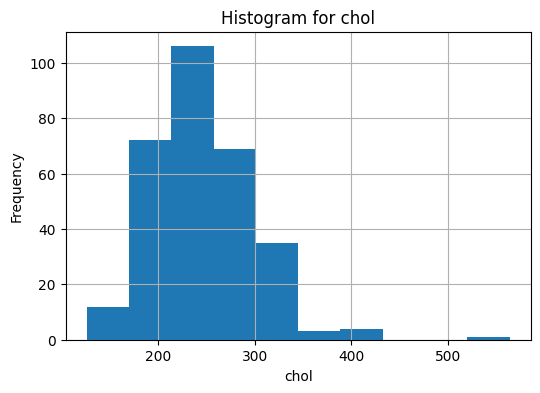

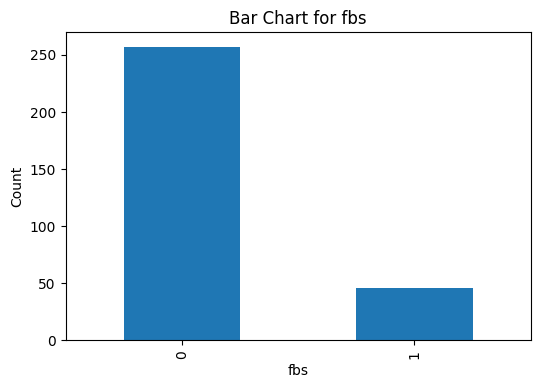

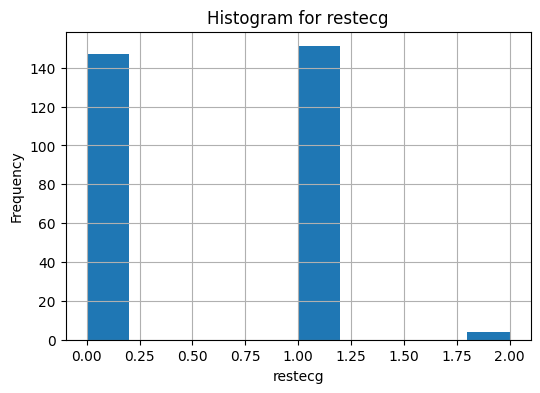

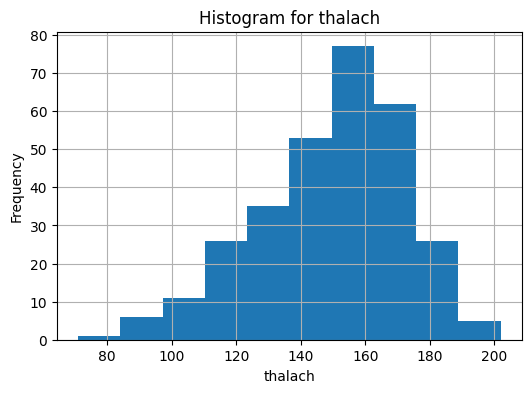

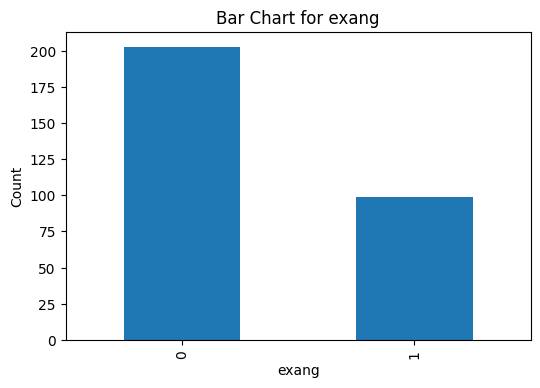

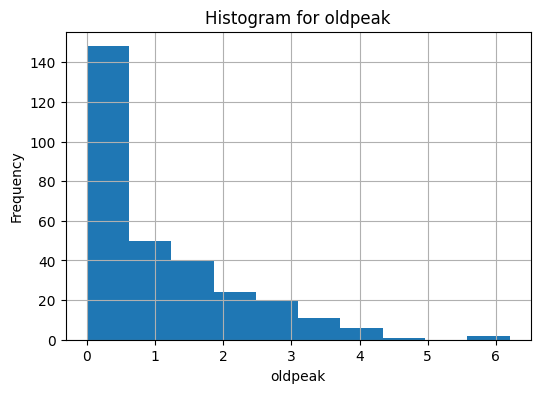

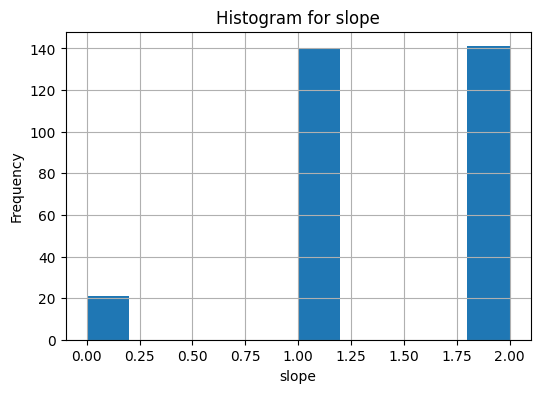

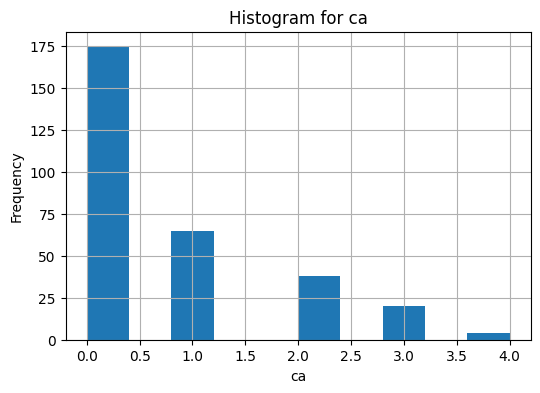

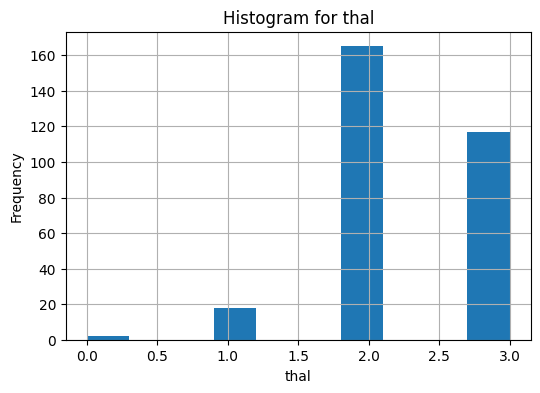

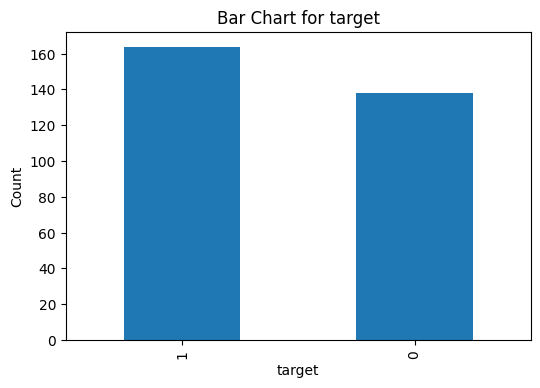

In [39]:
for name in df.columns:
    unique_values = df[name].dropna().unique()
    if set(unique_values).issubset({0, 1}):  # Check if the column is binary
        # Plot as a bar chart
        counts = df[name].value_counts()
        plt.figure(figsize=(6, 4))
        counts.plot(kind='bar')
        plt.title(f'Bar Chart for {name}')
        plt.xlabel(name)
        plt.ylabel('Count')
    else:
        # Plot as a histogram
        plt.figure(figsize=(6, 4))
        df[name].hist(bins=10)
        plt.title(f'Histogram for {name}')
        plt.xlabel(name)
        plt.ylabel('Frequency')
    plt.show()


After looking at these distribution plots, it looks like there are some outliers in the oldpeak, cholesteral, thal, and restecg. To remove data points for numerical data, we remove data points that fall outside of either above the 99th percentile or below the 1st percentile. 

In [40]:
def remove_outliers_numerical(df):
    outliers_removed = df.copy()
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            Q1 = df[column].quantile(0.005)
            Q3 = df[column].quantile(0.995)
            lower_bound = Q1
            upper_bound = Q3 
            outliers_removed = outliers_removed[(outliers_removed[column] >= lower_bound) & (outliers_removed[column] <= upper_bound)]
    return outliers_removed

def remove_outliers_categorical(df, threshold=5):
    outliers_removed = df.copy()
    for column in df.columns:
        if pd.api.types.is_categorical_dtype(df[column]):
            counts = df[column].value_counts()
            categories_to_remove = counts[counts < threshold].index
            outliers_removed = outliers_removed[~outliers_removed[column].isin(categories_to_remove)]
    return outliers_removed

# Remove outliers from categorical columns
df_cleaned = remove_outliers_categorical(df)

# Remove outliers from the dataset
df_cleaned = remove_outliers_numerical(df_cleaned)

# Print the shape of the cleaned dataset
print("Shape of the cleaned dataset:", df_cleaned.shape)
df_cleaned.to_csv('dataset/heart_outliers_removed.csv', index=False)


Shape of the cleaned dataset: (285, 14)


C:\Users\nicho\AppData\Local\Temp\ipykernel_22960\1899368299.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[column]):


C:\Users\nicho\AppData\Local\Temp\ipykernel_22960\108995047.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='target', y=feature, data=df, jitter=True, palette='Set2', dodge=True)


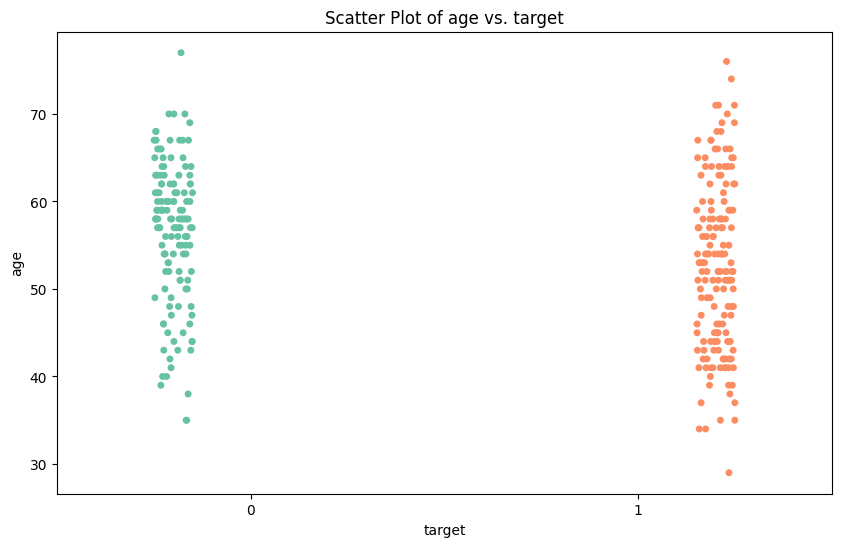

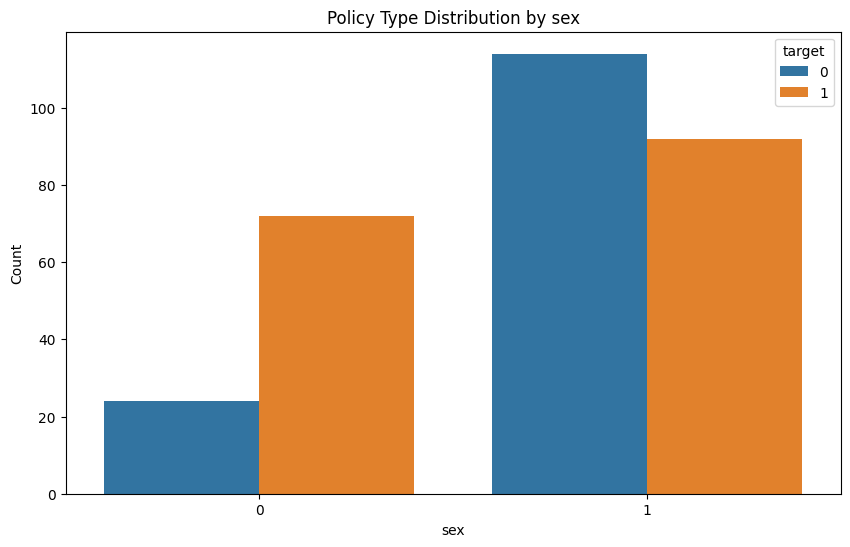

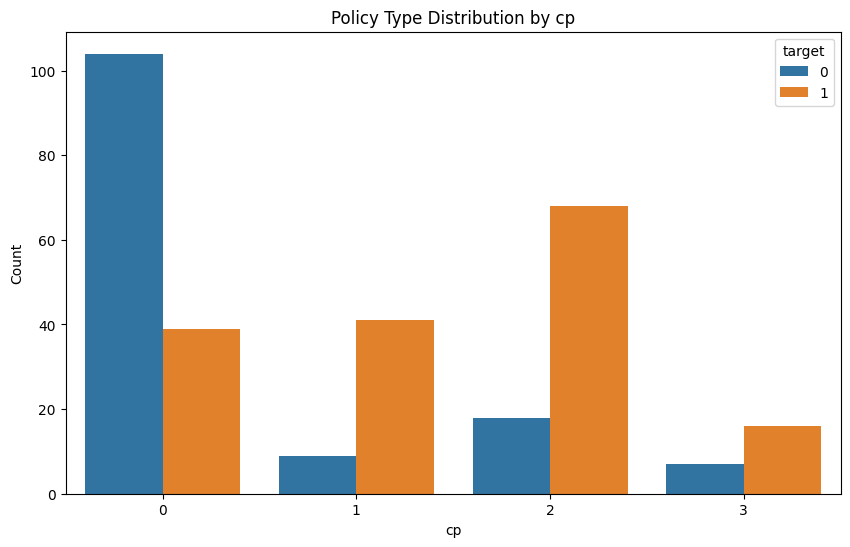

C:\Users\nicho\AppData\Local\Temp\ipykernel_22960\108995047.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='target', y=feature, data=df, jitter=True, palette='Set2', dodge=True)


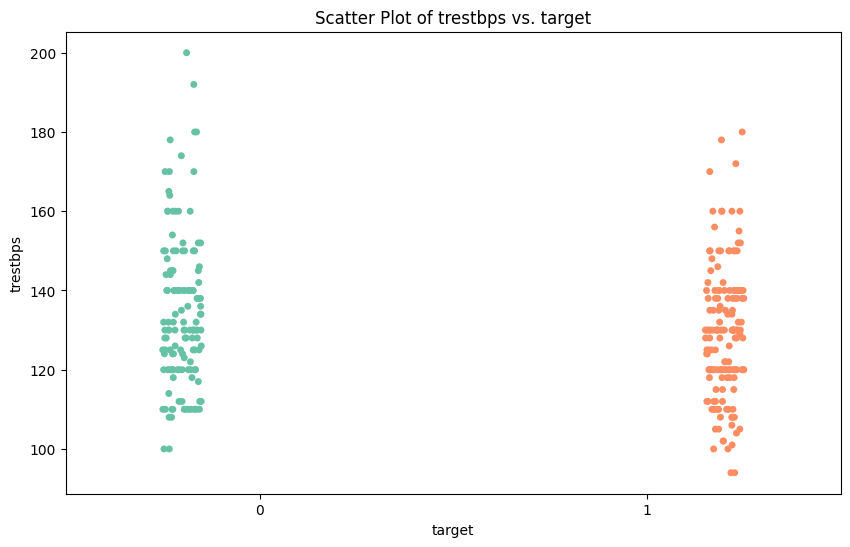

C:\Users\nicho\AppData\Local\Temp\ipykernel_22960\108995047.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='target', y=feature, data=df, jitter=True, palette='Set2', dodge=True)


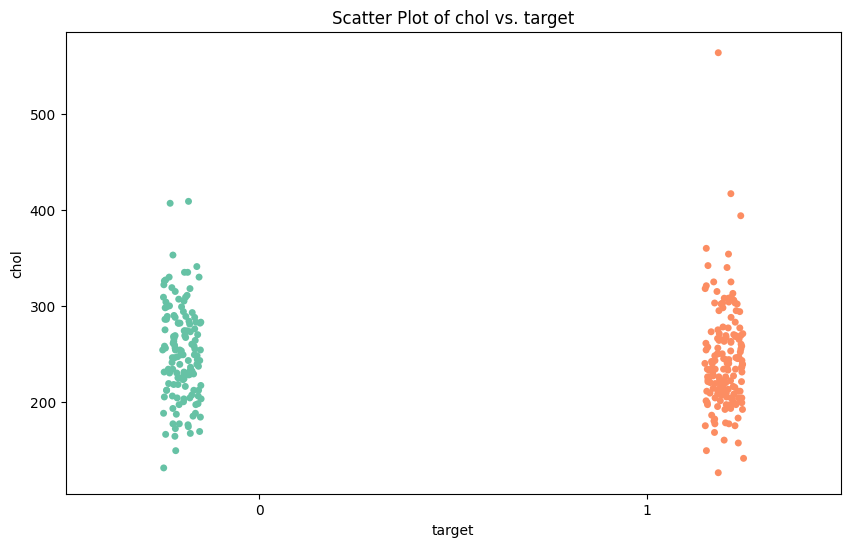

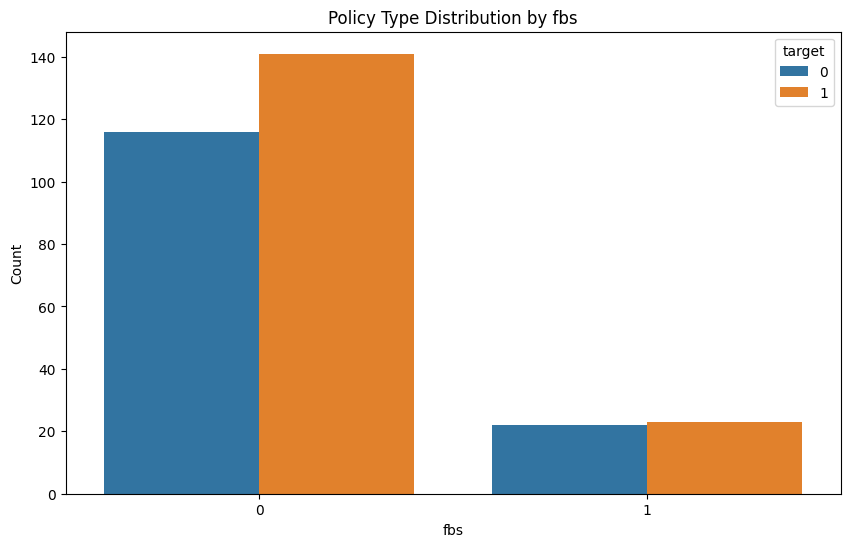

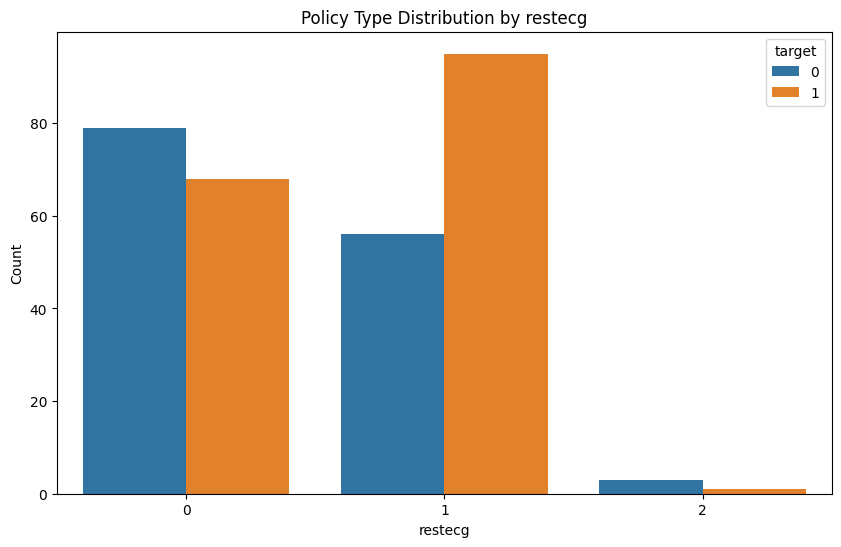

C:\Users\nicho\AppData\Local\Temp\ipykernel_22960\108995047.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='target', y=feature, data=df, jitter=True, palette='Set2', dodge=True)


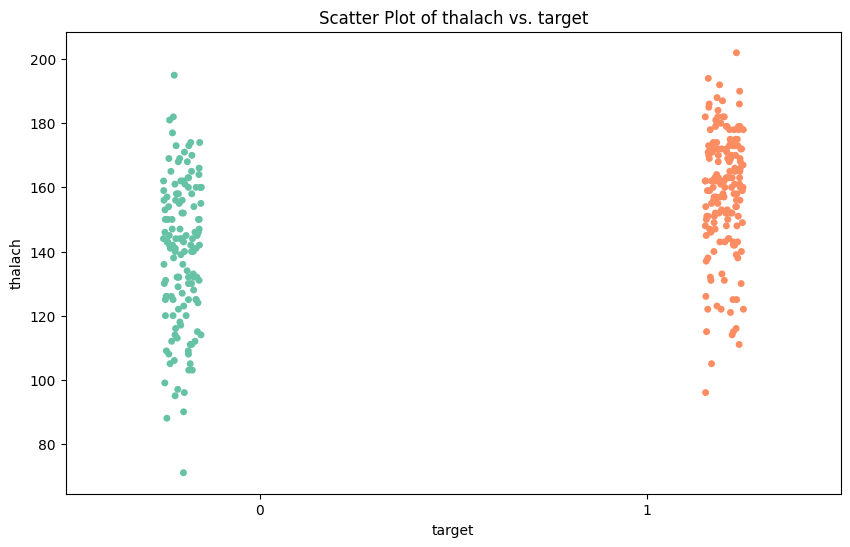

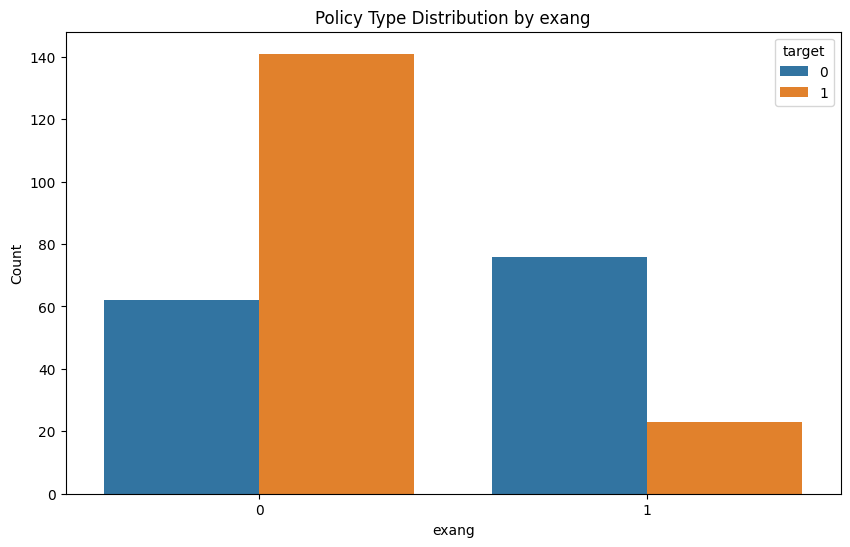

C:\Users\nicho\AppData\Local\Temp\ipykernel_22960\108995047.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='target', y=feature, data=df, jitter=True, palette='Set2', dodge=True)


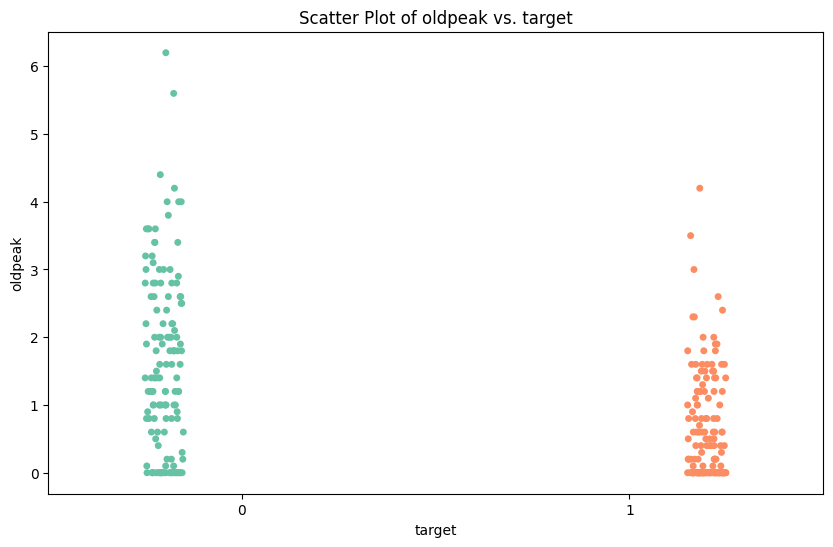

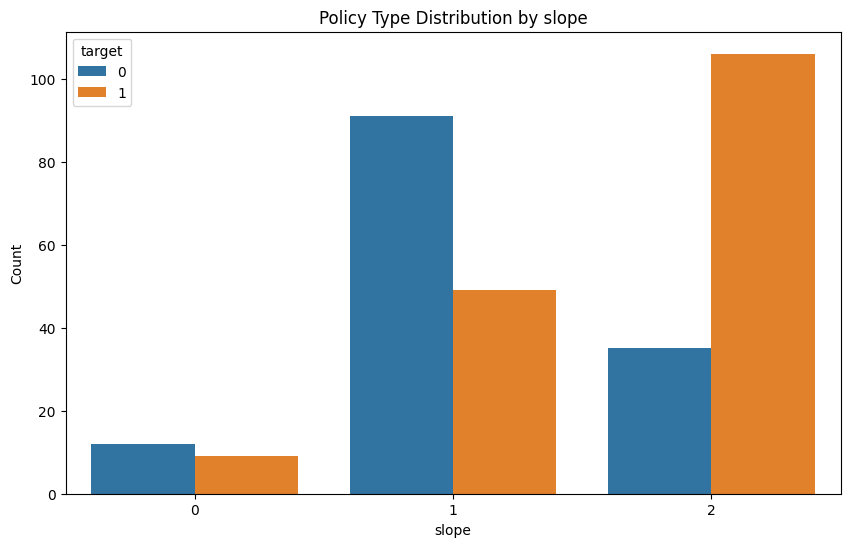

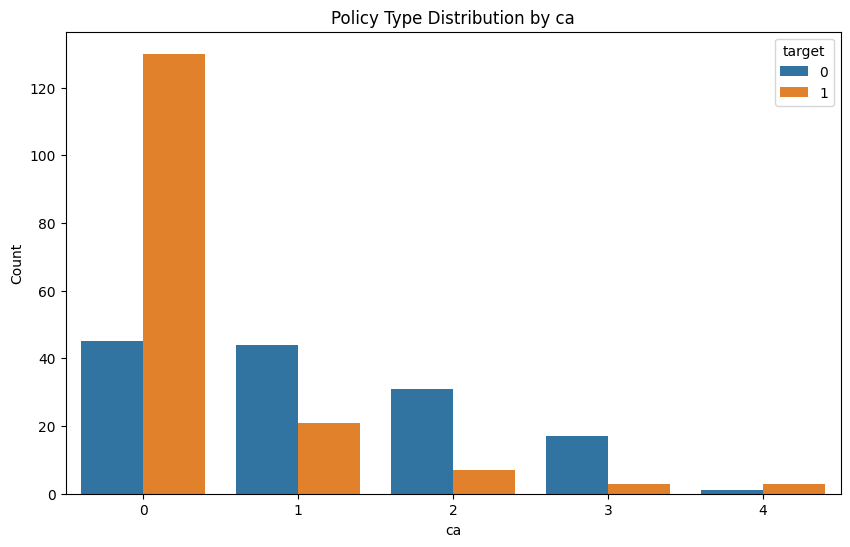

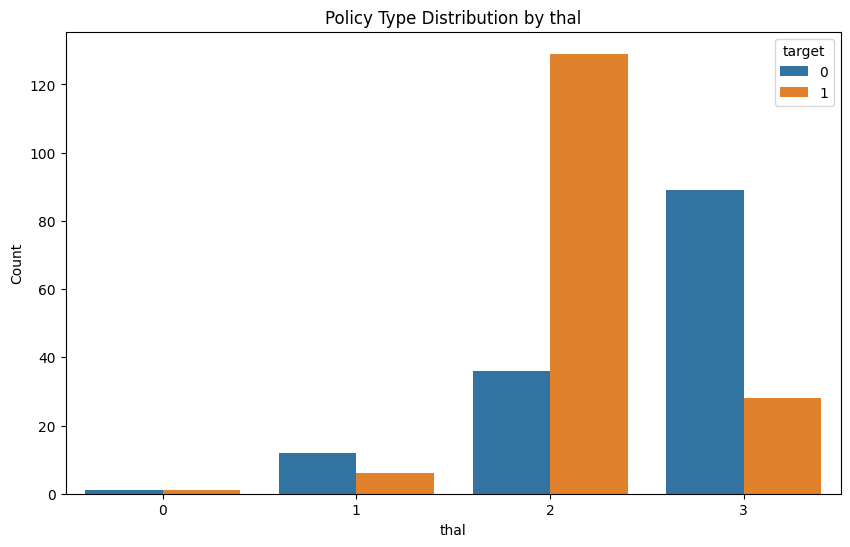

In [41]:
import seaborn as sns


scatter_plot_columns = ['age', 'trestbps', 'thalach', 'chol', 'oldpeak']

for feature in df.columns:
    if feature != 'target':
        plt.figure(figsize=(10, 6))
        if feature in scatter_plot_columns:
            sns.stripplot(x='target', y=feature, data=df, jitter=True, palette='Set2', dodge=True)
            plt.title('Scatter Plot of ' + feature + " vs. target")
            plt.xlabel('target')
            plt.ylabel(feature)
            plt.show()
            
        else:
            sns.countplot(x=feature, hue='target', data=df)
            plt.title(f'Policy Type Distribution by {feature}')
            plt.xlabel(feature)
            plt.ylabel('Count')
            plt.legend(title='target')
        plt.show()

In [42]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

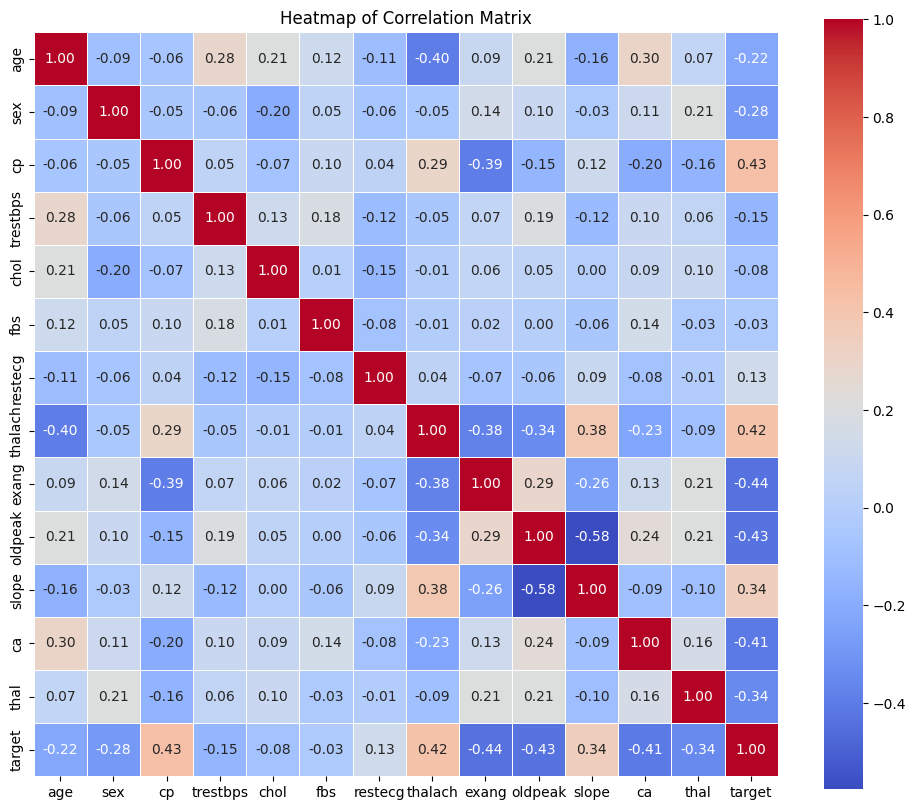

In [43]:
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True, linewidths=0.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

C:\Users\nicho\AppData\Local\Temp\ipykernel_22960\4289169430.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='coolwarm')


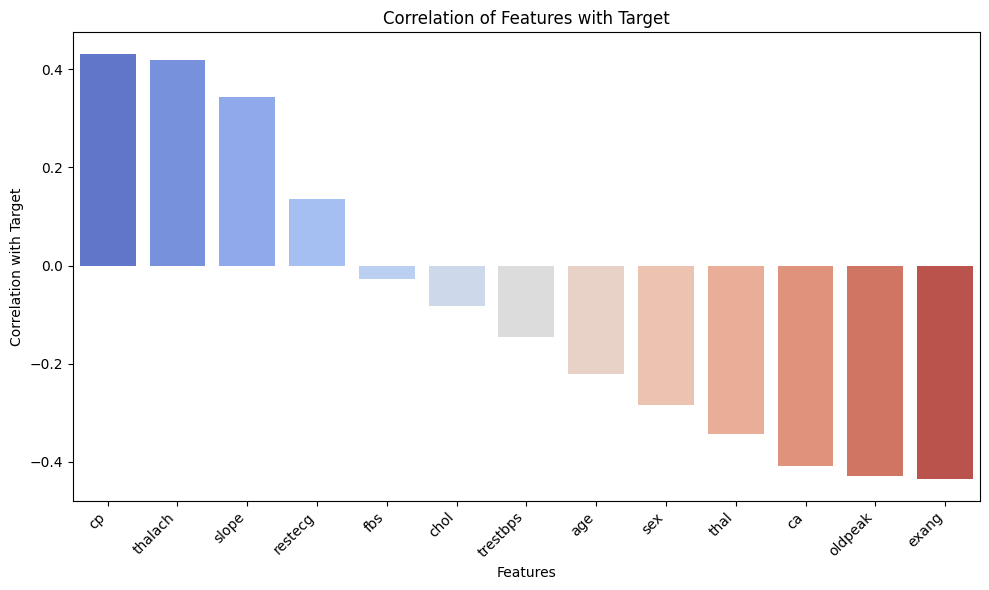

In [44]:
correlation_with_target = df.corr()['target'].drop('target').sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='coolwarm')
plt.title('Correlation of Features with Target')
plt.xlabel('Features')
plt.ylabel('Correlation with Target')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\nicho\AppData\Local\Temp\ipykernel_22960\4020564733.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.loc[final_features].index, y=correlation_with_target.loc[final_features].values, palette='coolwarm')


Selected Features: ['exang', 'cp', 'oldpeak', 'thalach']


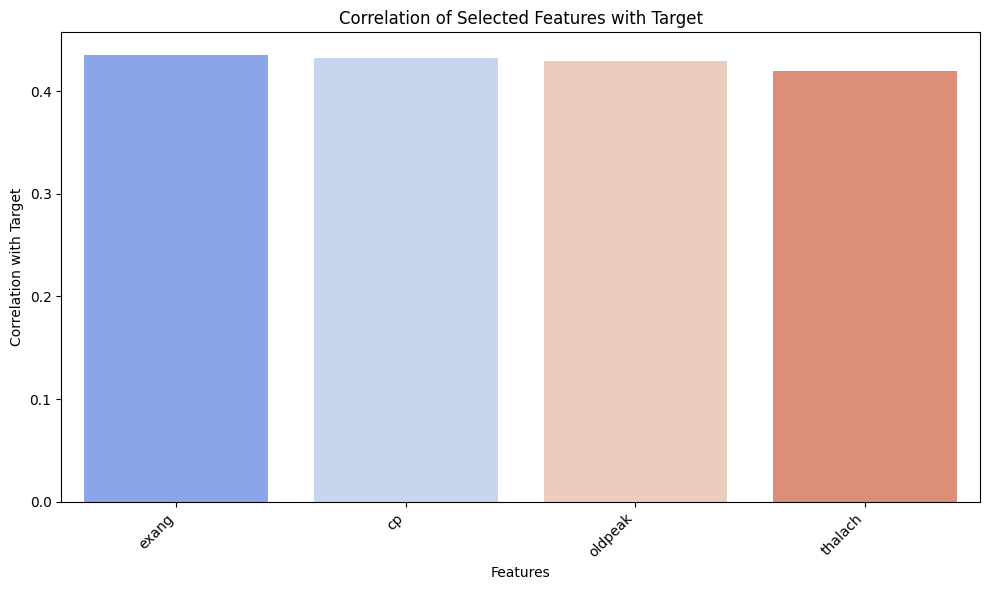

In [45]:
correlation_with_target = df.corr()['target'].drop('target').abs().sort_values(ascending=False)

# Filter features with correlation >= 0.4
relevant_features = correlation_with_target[correlation_with_target >= 0.41].index

# Create correlation matrix for the relevant features
selected_corr_matrix = df[relevant_features].corr().abs()

# Function to select features with low inter-correlation
def select_features(corr_matrix, threshold=0.41):
    selected_features = []
    for feature in corr_matrix.columns:
        if all(corr_matrix[feature][selected_features] < threshold):
            selected_features.append(feature)
    return selected_features

# Select features with inter-correlation below 0.41
final_features = select_features(selected_corr_matrix)

print("Selected Features:", final_features)

# Create a bar plot for correlation with the target
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.loc[final_features].index, y=correlation_with_target.loc[final_features].values, palette='coolwarm')
plt.title('Correlation of Selected Features with Target')
plt.xlabel('Features')
plt.ylabel('Correlation with Target')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

After narrowing down the features to one's whose correlation with the target variable is at least 0.41 and whose correlation with each other variable is less than 0.41, it appears that there are four variables who are highly correlated with the target and lowly correlated with other variables. 